<a href="https://colab.research.google.com/github/nagusubra/Solar_panel_dust_detection/blob/main/Solar_panel_dust_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries and modules

In [1]:
!pip install -q tensorflow-model-optimization
!pip install openpyxl
!pip install xlsxwriter

import xlsxwriter
import openpyxl
from openpyxl import Workbook
from openpyxl.drawing.image import Image

import tempfile
from tensorflow import keras
import tensorflow_model_optimization as tfmot

from tqdm import tqdm_notebook as tqdm
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import cross_val_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

import os
import zipfile

In [3]:
# mounting google drive (if you are using Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# from os import listdir
# from os.path import isfile, join

# mypath = '/content/drive/MyDrive/Solar_panel_dust_detection/dataset_2/dirty'

# onlyfiles = [ f  for f in listdir(mypath) if isfile(join(mypath, f))]

# onlyfiles

In [5]:
# from os import listdir
# from os.path import isfile, join

# mypath = '/content/drive/MyDrive/Solar_panel_dust_detection/dataset_2/dirty'

# onlyfiles = [ os.rename(join(mypath, f), join(mypath, f.split(".")[0] + "_dirty" + ".jpg"))  for f in listdir(mypath) if isfile(join(mypath, f))]

# onlyfiles

# Evaluation function

In [6]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  return os.path.getsize(zipped_file)

def evaluate_model(model_path, model_info, val_dataset):

  # Evaluate test accuracy and test loss
  model = tf.keras.models.load_model(model_path)
  test_loss, test_acc = model.evaluate(val_dataset, verbose=0)

  # Evaluate Model Size
  model_size = get_gzipped_model_size(model_path)

  # Evaluate Inference Time
  startTime = time.time()
  prediction = model.predict(val_dataset)
  executionTime = (time.time() - startTime)/len(val_dataset)

  # Print
  print('\nModel Accuracy:', test_acc*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is: ", executionTime, "s")

  # Build Evalution dataframe
  evulation_dict = {
                      "Evaluation type": "Evualation",
                      "Model Information": model_info,
                      "Accuracy": str(test_acc*100) + " %",
                      "Loss": str(test_loss*100) + " %",
                      "Model Size": str(model_size) + " bytes",
                      "Inference Time": str(executionTime) + " sec"
                    }
  
  evulation_df = pd.DataFrame.from_dict(evulation_dict, orient='index').reset_index()


  return test_acc, model_size, executionTime, evulation_df

# Build base model

In [ ]:
def SolNet(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)
  SolNet.save('models/solnet.hdf5')
  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

#Base Model

In [ ]:
def SolNet(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)
  SolNet.save('models/solnet.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet'+str(datetime.datetime.today().date())+'.h5')
  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

In [ ]:
def evaluate():
  path = "/content/models/solnet.hdf5"
  solnet = load_model(path, compile=False)
  # history = solnet.history()
  plt.plot(history.history['loss'])
  plt.plot(history.history['acc'])
  plt.title('acc loss vs epoch')
  plt.xlabel('epoch')
  plt.legend(['loss', 'acc'], loc='upper left')
  plt.show()

In [ ]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
batch_size = 32
#location = 'dataset/'
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"
label_mode = 'binary'
seed = 10 #changed for each fold made manually
epochs=30
#epochs=5


class_names = ['clean', 'dirty']
in_size = [227, 227, 3]

tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1],
                                          subset = 'validation', batch_size=batch_size, validation_split=.2)

in_size = [227, 227, 3]
SolNet = SolNet(in_size)



startTime = time.time()
history = SolNet.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)
executionTime = (time.time() - startTime)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024

In [ ]:
print(history.history)

{'loss': [1.3287363052368164, 0.5634193420410156, 0.5111455321311951, 0.4731604754924774, 0.4032560884952545, 0.3881598711013794, 0.31916534900665283, 0.17050495743751526, 0.13634862005710602, 0.18331176042556763, 0.13211464881896973, 0.2388705164194107, 0.13867801427841187, 0.13399434089660645, 0.26728636026382446, 0.10856659710407257, 0.1045788899064064, 0.21800419688224792, 0.18994426727294922, 0.13771790266036987, 0.05984649434685707, 0.13090425729751587, 0.08103565126657486, 0.14808224141597748, 0.16438354551792145, 0.07622100412845612, 0.0836929902434349, 0.04517742618918419, 0.0693543553352356, 0.06658089905977249], 'acc': [0.7508680820465088, 0.8680555820465088, 0.8871527910232544, 0.8932291865348816, 0.9166666865348816, 0.9296875, 0.9348958134651184, 0.9618055820465088, 0.9713541865348816, 0.9670138955116272, 0.9704861044883728, 0.9609375, 0.9826388955116272, 0.9704861044883728, 0.9722222089767456, 0.9809027910232544, 0.9809027910232544, 0.9661458134651184, 0.9800347089767456,

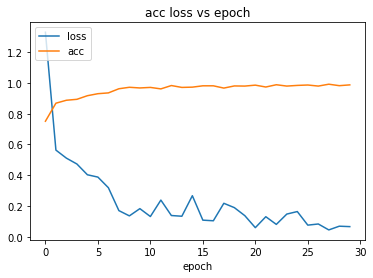

In [ ]:
evaluate()

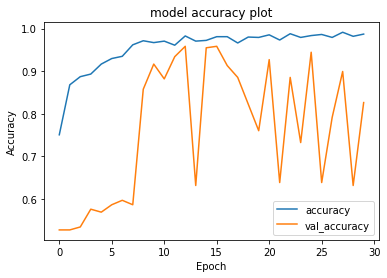

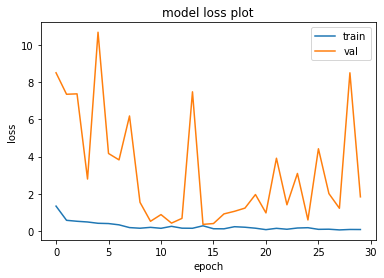

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.title('model accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
print("Inference Time is", executionTime/60, "mins")

Inference Time is 65.25891411304474 mins


# Updated Solnet model

In [5]:
def SolNet_updated(in_size, learning_rate, model_path):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)


  SolNet = Model(inputs = i, outputs = o)



  # SolNet.save('models/solnet.hdf5')
  # SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.compile(optimizer=Adam(learning_rate), loss=binary_crossentropy, metrics=['acc'])
  SolNet.save(model_path)
  SolNet.summary()
  return SolNet

In [6]:
model_path = '/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+ str(datetime.datetime.today().date()) + '.h5'
model_plot_path = '/content/drive/MyDrive/Solar_panel_dust_detection/plots/'+ str(datetime.datetime.today().date())
model_excel_file_path = '/content/drive/MyDrive/Solar_panel_dust_detection/evaluation/'+ str(datetime.datetime.today().date())
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"

batch_size = 32
label_mode = 'binary'
seed = 10 #changed for each fold made manually
epochs= 2
in_size = [227, 227, 3]

class_names = ['clean', 'dirty']
test_labels = class_names

tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1],
                                          subset = 'validation', batch_size=batch_size, validation_split=.2)

# in_size = [227, 227, 3]
SolNet_model = SolNet_updated(in_size, 0.00001, model_path)



startTime = time.time()
history = SolNet_model.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)
executionTime = (time.time() - startTime)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.


KeyboardInterrupt: ignored

In [ ]:
model_info = "batch_size: " + str(batch_size) + " and epochs: " + str(epochs) + " and in_size: " + str(in_size)
print(model_info)
print("Inference Time is", executionTime/60, "mins")

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.title('model accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(model_plot_path + '_model_accuracy_plot.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig(model_plot_path + '_model_loss_plot.png')
plt.show()

In [ ]:
# Evaluate Inference Time
startTime = time.time()
model = tf.keras.models.load_model(model_path)
test_loss, test_acc = model.evaluate(val_dataset, verbose=0)
prediction = model.predict(val_dataset)
executionTime = (time.time() - startTime)/len(val_dataset)
print(executionTime)
print(test_acc)

9/9 [==============================] - 22s 34ms/step
5.197857062021892
0.4722222089767456


In [ ]:
test_acc, model_size, executionTime, evulation_df = evaluate_model(model_path, model_info, val_dataset)

9/9 [==============================] - 24s 36ms/step

Model Accuracy: 52.77777910232544 %
Model Size: 212499172.00 bytes
Inference Time is:  2.6470077302720814 s


In [ ]:
evulation_df

,index,0
0,Evaluation type,Evualation
1,Model Information,batch_size: 32 and epochs: 2 and in_size: [227...
2,Accuracy,52.77777910232544 %
3,Loss,333.86545181274414 %
4,Model Size,212499172 bytes
5,Inference Time,2.6470077302720814 sec


In [ ]:
path = model_excel_file_path + '_model_evaluation.xlsx'

with pd.ExcelWriter(path) as writer:
  # writer.book = openpyxl.load_workbook(path)
  evulation_df.to_excel(writer, sheet_name='Model_evaluation')
  pd.DataFrame().to_excel(writer, sheet_name='Plots')
  

  worksheet = writer.sheets['Plots']
  worksheet.insert_image('A1', model_plot_path + '_model_accuracy_plot.png')
  worksheet.insert_image('K1', model_plot_path + '_model_loss_plot.png')
  writer.save()

#Loop based hyperparameter optimization

In [7]:
def SolNet_updated_for_loop(in_size, learning_rate, model_path):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)


  SolNet = Model(inputs = i, outputs = o)



  # SolNet.save('models/solnet.hdf5')
  # SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.compile(optimizer=Adam(learning_rate), loss=binary_crossentropy, metrics=['acc'])
  SolNet.save(model_path)
  SolNet.summary()
  return SolNet

In [8]:
def plot_history(history, model_plot_path, iteration_number):
  
  model_accuracy_plot_modified = model_plot_path + "_model_iteration_" + str(iteration_number) + "_model_accuracy_plot.png"
  model_loss_plot_modified = model_plot_path + "_model_iteration_" + str(iteration_number) + "_model_loss_plot.png"
  
  plt.plot(history.history['acc'], label='accuracy')
  plt.plot(history.history['val_acc'], label = 'val_accuracy')
  plt.title('model accuracy plot')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  
  plt.savefig(model_accuracy_plot_modified)
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss plot')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.savefig(model_loss_plot_modified)
  plt.show()

  return model_accuracy_plot_modified, model_loss_plot_modified

In [9]:
def save_execution_trial(evluation_df, model_excel_file_path, model_accuracy_plot_modified, model_loss_plot_modified, iteration_number):
  path = model_excel_file_path + "_model_iteration_" + str(iteration_number) + '_model_evaluation.xlsx'

  with pd.ExcelWriter(path) as writer:
    # writer.book = openpyxl.load_workbook(path)
    evluation_df.to_excel(writer, sheet_name='Model_evaluation')
    pd.DataFrame().to_excel(writer, sheet_name='Plots')
    

    worksheet = writer.sheets['Plots']
    worksheet.insert_image('A1', model_accuracy_plot_modified)
    worksheet.insert_image('K1', model_loss_plot_modified)
    writer.save()

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
The model info:  batch_size: 16 and epochs: 10 and in_size: [100, 100, 3] and lr: 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 23, 23, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                          

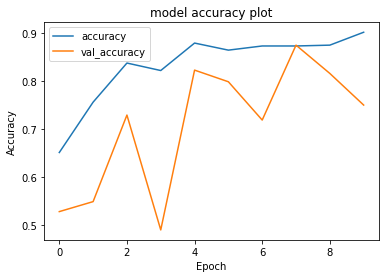

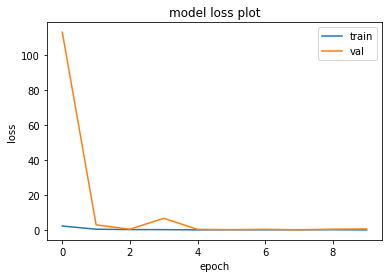

18/18 [==============================] - 20s 648ms/step

Model Accuracy: 55.55555820465088 %
Model Size: 90201289.00 bytes
Inference Time is:  1.1475220388836331 s
The evaluation df: 
                index                                                  0
0    Evaluation type                                         Evualation
1  Model Information  batch_size: 16 and epochs: 10 and in_size: [10...
2           Accuracy                                55.55555820465088 %
3               Loss                                68.58421564102173 %
4         Model Size                                     90201289 bytes
5     Inference Time                             1.1475220388836331 sec 



/usr/local/lib/python3.8/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
The model info:  batch_size: 16 and epochs: 10 and in_size: [136, 136, 3] and lr: 0.001
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 136, 136, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 96)       0         
 2D)                                                             
                        

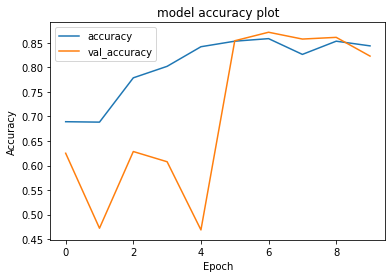

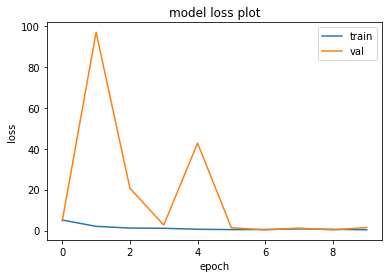

18/18 [==============================] - 21s 715ms/step

Model Accuracy: 47.22222089767456 %
Model Size: 109298214.00 bytes
Inference Time is:  2.2827785677380033 s
The evaluation df: 
                index                                                  0
0    Evaluation type                                         Evualation
1  Model Information  batch_size: 16 and epochs: 10 and in_size: [13...
2           Accuracy                                47.22222089767456 %
3               Loss                                746.3394165039062 %
4         Model Size                                    109298214 bytes
5     Inference Time                             2.2827785677380033 sec 



/usr/local/lib/python3.8/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
The model info:  batch_size: 16 and epochs: 10 and in_size: [204, 204, 3] and lr: 0.001
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 204, 204, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 49, 49, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 49, 49, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                        

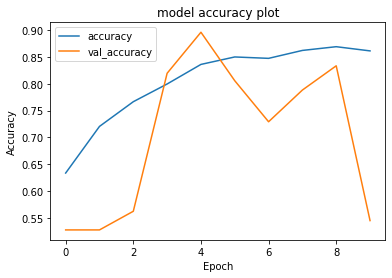

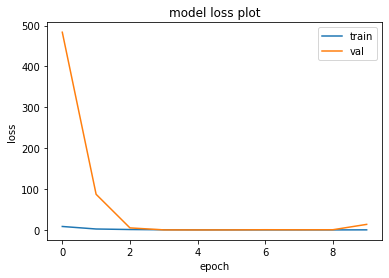

18/18 [==============================] - 28s 972ms/step

Model Accuracy: 52.77777910232544 %
Model Size: 170691534.00 bytes
Inference Time is:  1.5727844370736017 s
The evaluation df: 
                index                                                  0
0    Evaluation type                                         Evualation
1  Model Information  batch_size: 16 and epochs: 10 and in_size: [20...
2           Accuracy                                52.77777910232544 %
3               Loss                                264.0308141708374 %
4         Model Size                                    170691534 bytes
5     Inference Time                             1.5727844370736017 sec 



/usr/local/lib/python3.8/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
The model info:  batch_size: 16 and epochs: 10 and in_size: [227, 227, 3] and lr: 0.001
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_15 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                        

In [ ]:
model_path = '/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+ str(datetime.datetime.today().date())
model_plot_path = '/content/drive/MyDrive/Solar_panel_dust_detection/plots/'+ str(datetime.datetime.today().date())
model_excel_file_path = '/content/drive/MyDrive/Solar_panel_dust_detection/evaluation/'+ str(datetime.datetime.today().date())
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"



# batch_sizes = [16,32,64,128]
batch_sizes = [32,64]

# epoch_list = [10, 15, 20, 30]
epoch_list = [10, 20]

# learning_rates = [0.001, 0.0001 , 0.00001, 0.000001]
learning_rates = [0.0001 , 0.00001]

# in_sizes =  [
#                 [100, 100, 3],
#                 [136, 136, 3],
#                 [204, 204, 3],
#                 [227, 227, 3],
#             ]

in_sizes =  [
                [136, 136, 3],
                [227, 227, 3],
            ]

label_mode = 'binary'
seed = 10 #changed for each fold made manually
class_names = ['clean', 'dirty']

cnt = 0
for batch_size in batch_sizes:
  for epoch in epoch_list:
    for learning_rate in learning_rates:
      for in_size in in_sizes:

        tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

        val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                                  seed=seed, labels='inferred', image_size=in_size[:-1],
                                                  subset = 'validation', batch_size=batch_size, validation_split=.2)
        
        model_path_modified = model_path + "_model_iteration_" + str(cnt) + ".h5"
        model_info = "batch_size: " + str(batch_size) + " and epochs: " + str(epoch) + " and in_size: " + str(in_size) + " and lr: " + str(learning_rate)
        print("The model info: ", model_info)

        SolNet_model = SolNet_updated_for_loop(in_size, learning_rate, model_path_modified)
        
        history = SolNet_model.fit(tr_dataset, validation_data=val_dataset, epochs=epoch, batch_size=batch_size)
        model_accuracy_plot_modified, model_loss_plot_modified = plot_history(history, model_plot_path, cnt)

        test_acc, model_size, executionTime, evluation_df = evaluate_model(model_path_modified, model_info, val_dataset)
        print("The evaluation df: \n", evluation_df, "\n")

        save_execution_trial(evluation_df, model_excel_file_path, model_accuracy_plot_modified, model_loss_plot_modified, cnt)

        cnt += 1